# Тестирование работы многоголового трансформера

In [1]:
import sys
import os
current_dir = os.path.abspath('')
project_root = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, project_root)


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from gensim import models
import warnings
from sklearn.model_selection import train_test_split
rng = np.random.default_rng(51)

In [3]:
warnings.filterwarnings("ignore")

## Предобработка и разведочный анализ данных:

In [4]:
data=pd.read_csv('../data/russian_comments_from_2ch_pikabu.csv')

In [5]:
sents=data[['translated']].values.reshape(-1).tolist()

Предобработаем текст в предложениях:

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):#Предобработка текста (перевод в нижний регистр, токенизация и удаление стоп-слов)
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ivan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


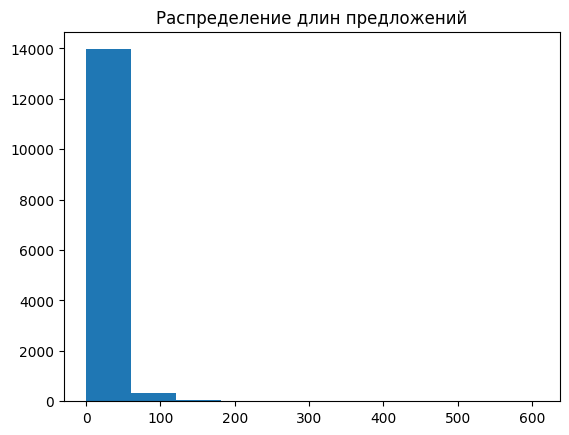

In [7]:
preprocessed_sentences=[]#Массив с предобработанными
targets=np.array([])
lenghts=[]
y=data[['toxic']].to_numpy().reshape(-1).astype('int')
for i, sentence in enumerate(sents):
    prepocessed_sentence=preprocess_text(sentence)#Предобраюотка предложения
    l=len(prepocessed_sentence)
    lenghts.append(l)
    if l>0 and l<=100:#В целях экономии памяти удаляем предложения с длиной больше 100. Пустые тоже не берём
        preprocessed_sentences.append(prepocessed_sentence)
        targets=np.append(targets,y[i])#Добавление таргета для предложения в выборку
plt.hist(lenghts) 
plt.title('Распределение длин предложений')
plt.show()

Векторизация предложений:

In [8]:
model = models.Word2Vec(sentences=preprocessed_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)#Обучение на предложениях модели word2vec (skipgram), длина эмбеддинга - 100

Применим позиционное кодирование:

In [9]:
embeddings=[]
for sentence in preprocessed_sentences:
    emb=np.array([])
    for i, word in enumerate(sentence):#кодируем отдельное слово в предложении
        embed=model.wv[word]
        emb=np.append(emb,model.wv[word])#Получение эмбеддинга слова
    emb=emb.reshape(-1,100)
    #Кодирование позиции
    position = np.arange(0, emb.shape[0])[:, None]
    div_term=np.power(10000, -np.arange(0, 100, 2)/100)[None, :]
    pe = np.zeros((emb.shape[0], 100))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    emb+=pe
    embeddings.append(emb.reshape(-1,100))
    

In [10]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, targets.astype('int'), test_size=0.2, random_state=2, stratify=targets)

## Обучение и тестирование модели

In [ ]:
from transformers.Transformer import BatchNormalizator, Transformer

In [12]:
bn=BatchNormalizator(100)#Создание двух батч-нормализаторов
bn_2=BatchNormalizator(100)

In [13]:
trans=Transformer(n_heads=16,n_attention_out=150,n_mlp_neurons=500,embedding_len=100) #Объявление трансформера

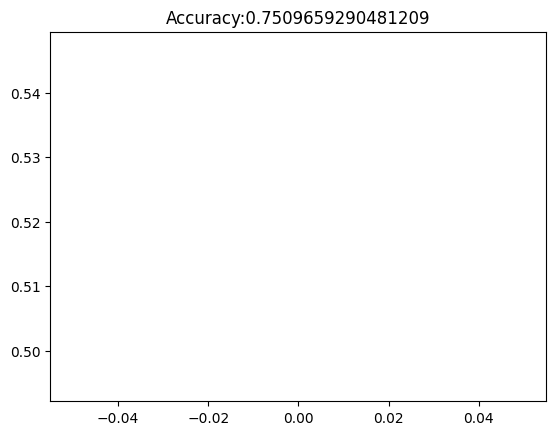

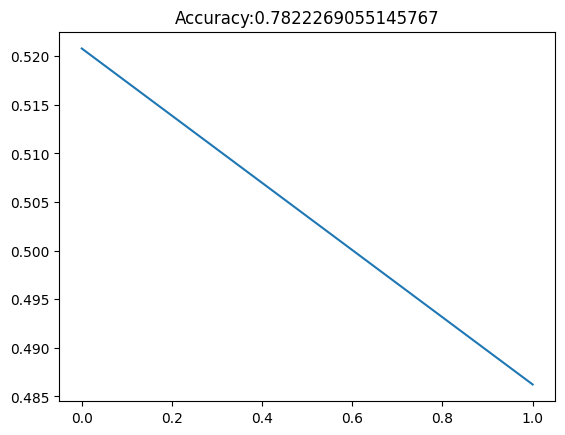

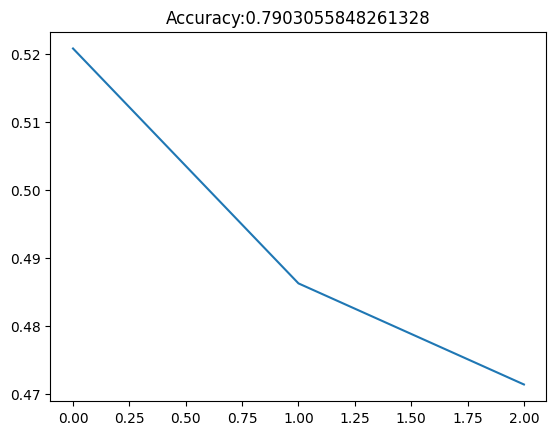

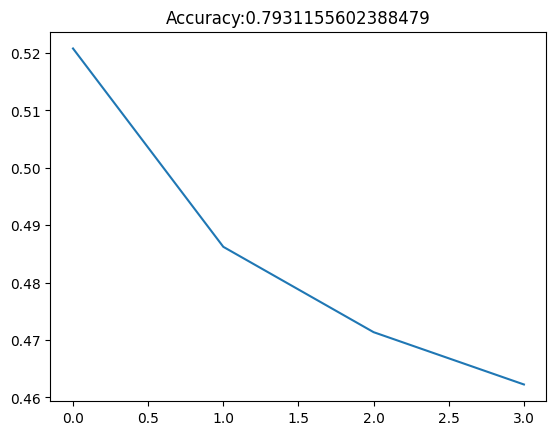

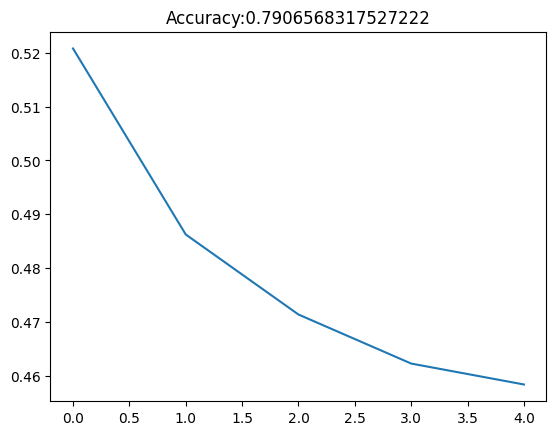

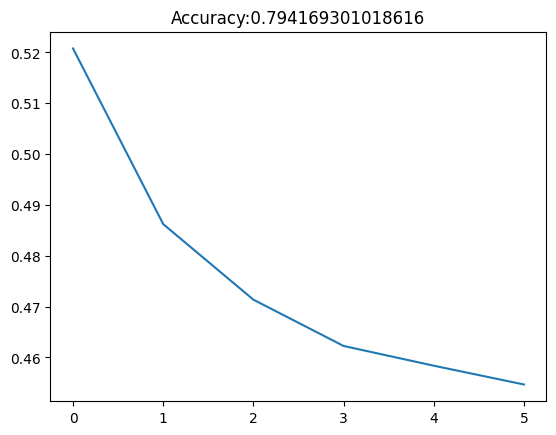

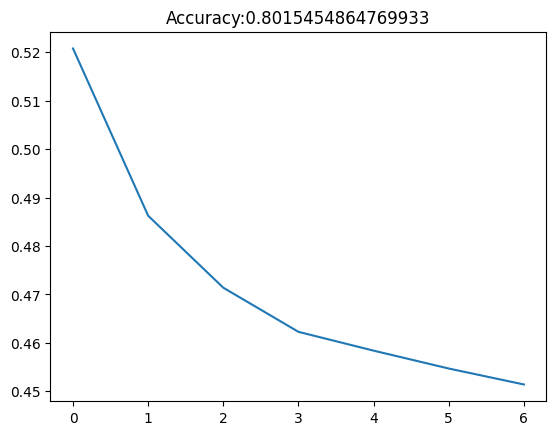

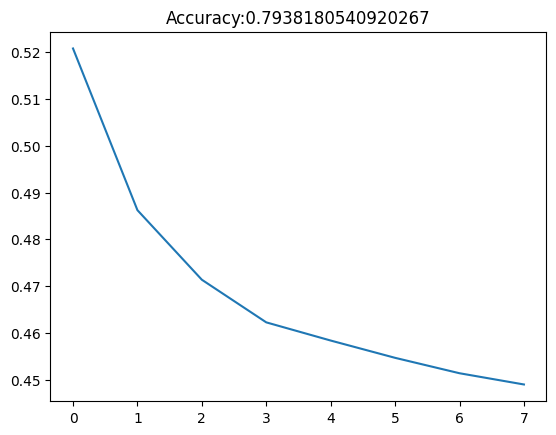

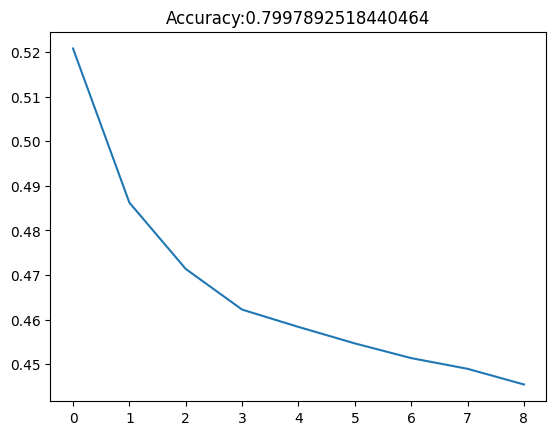

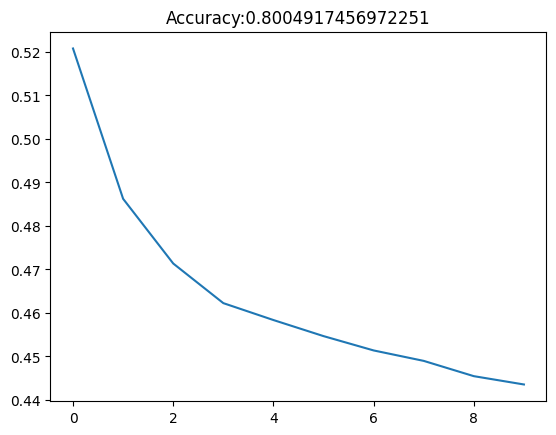

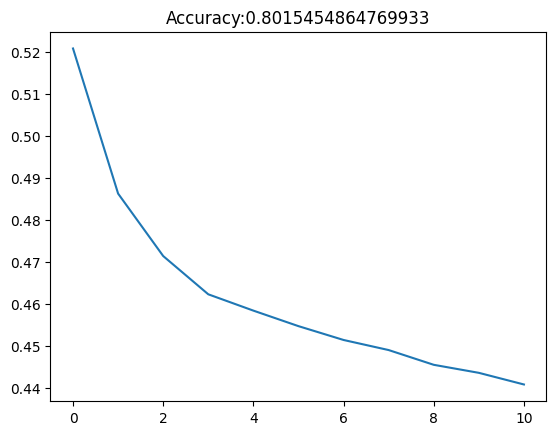

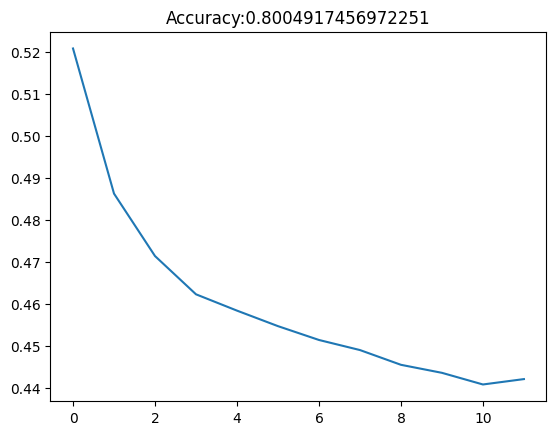

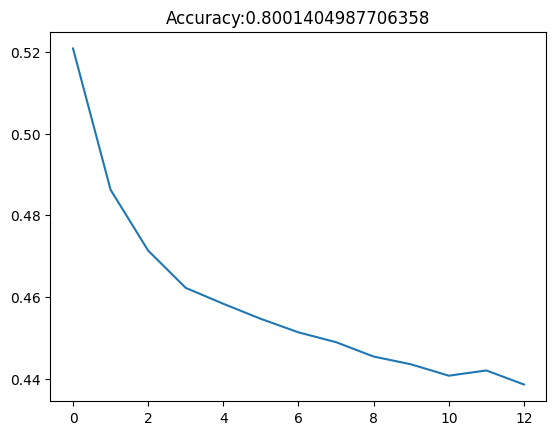

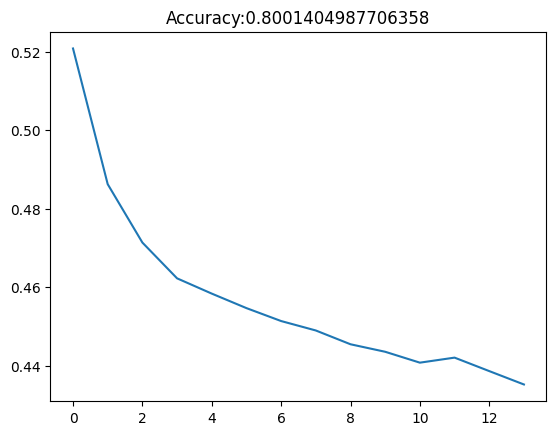

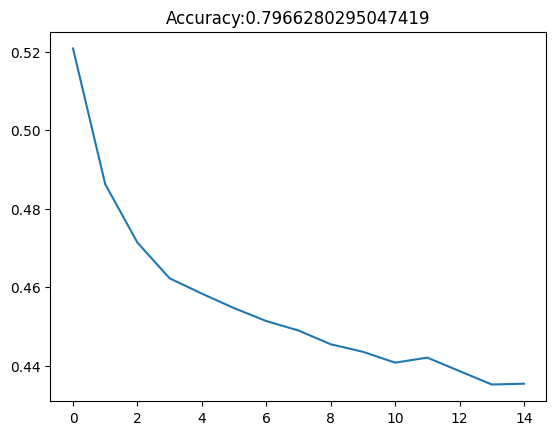

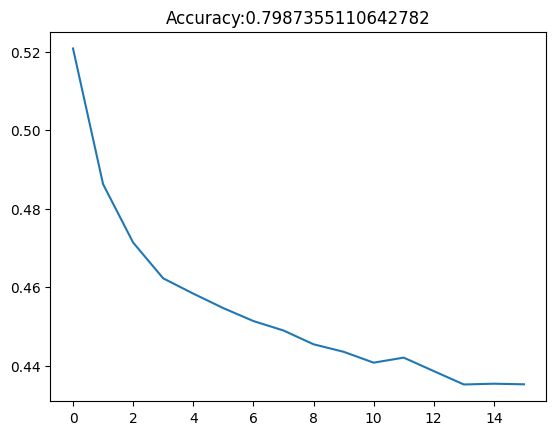

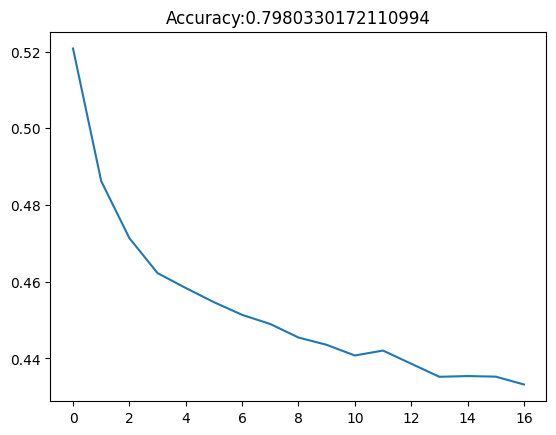

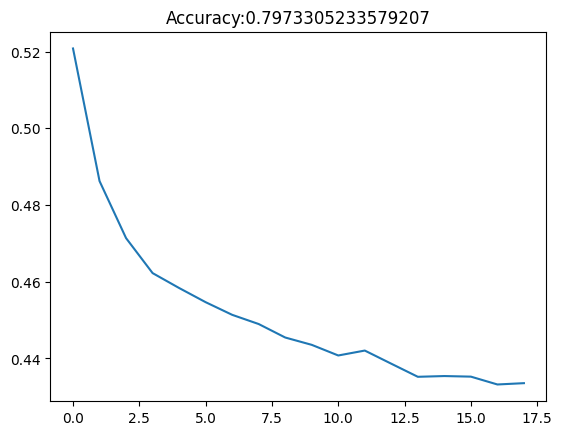

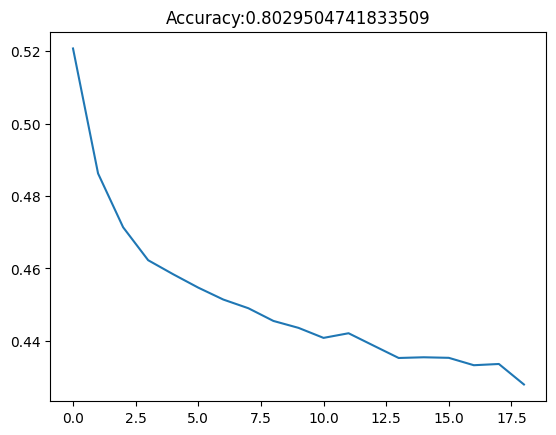

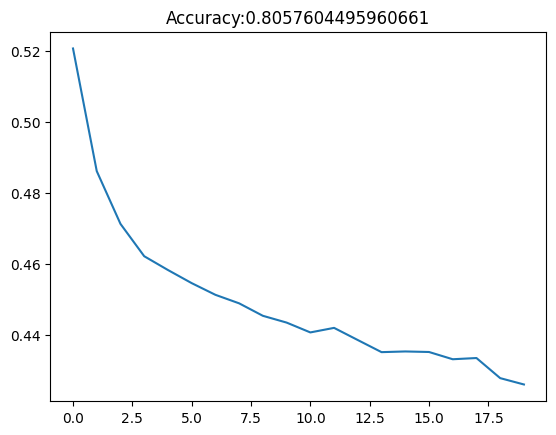

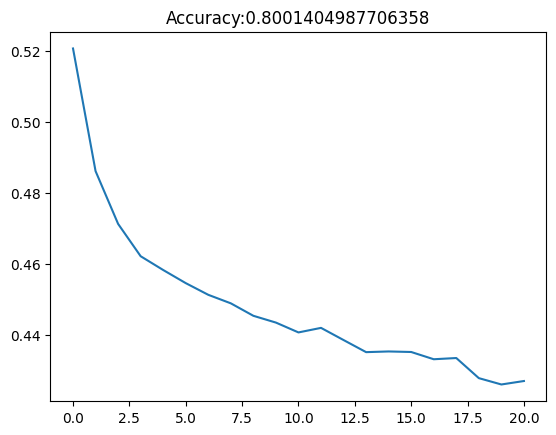

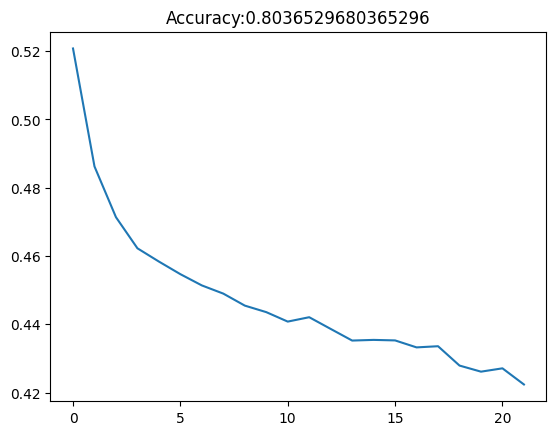

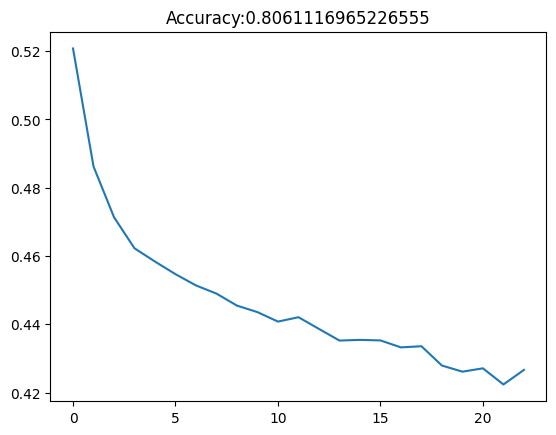

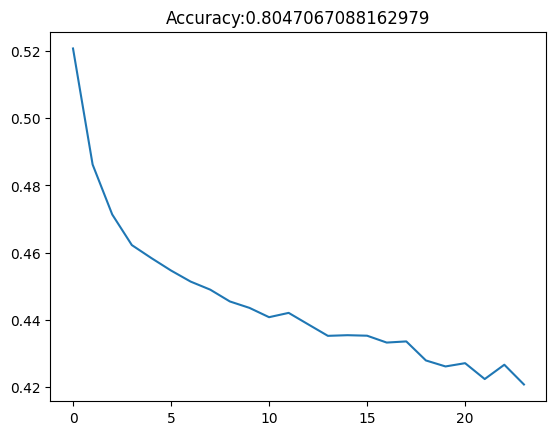

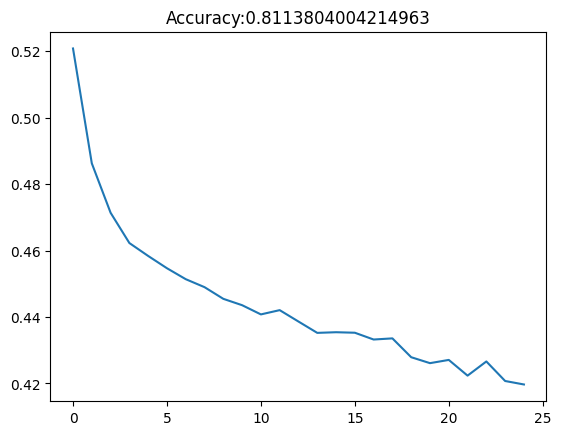

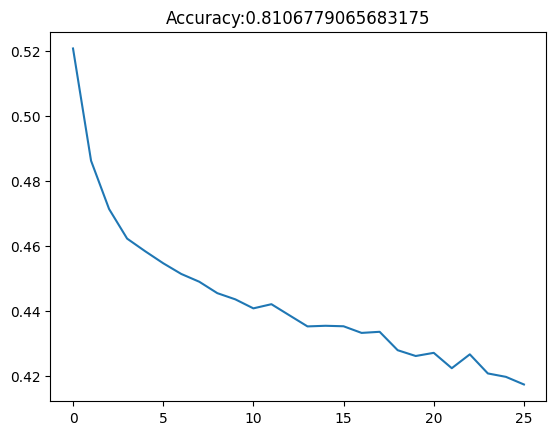

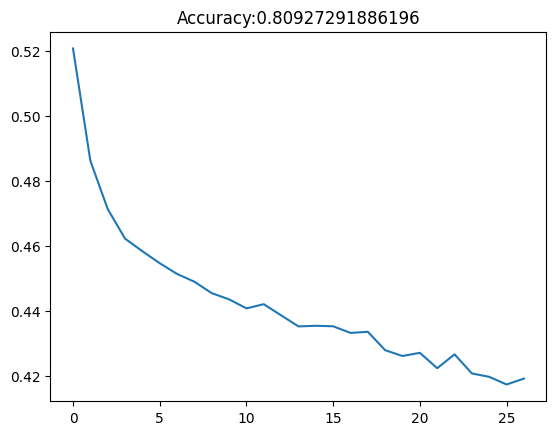

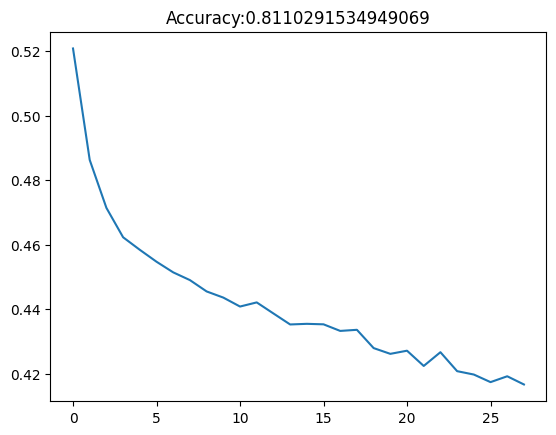

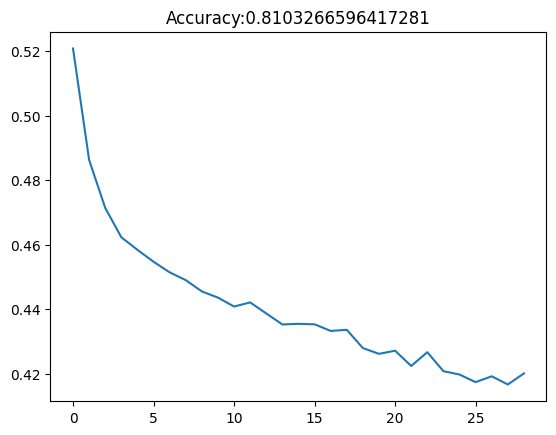

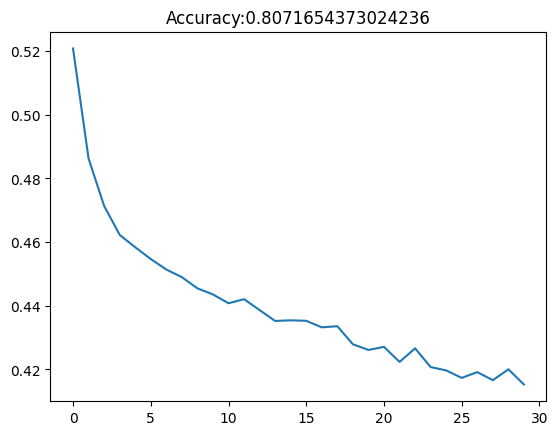

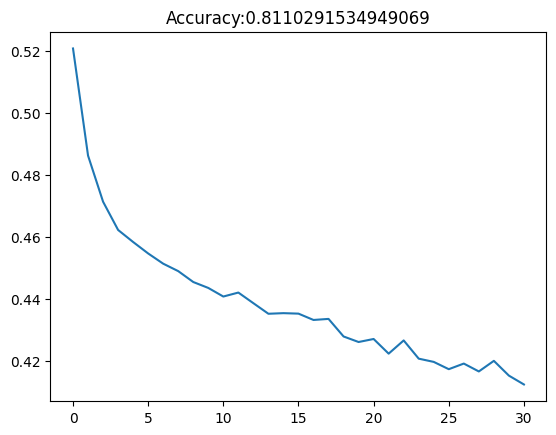

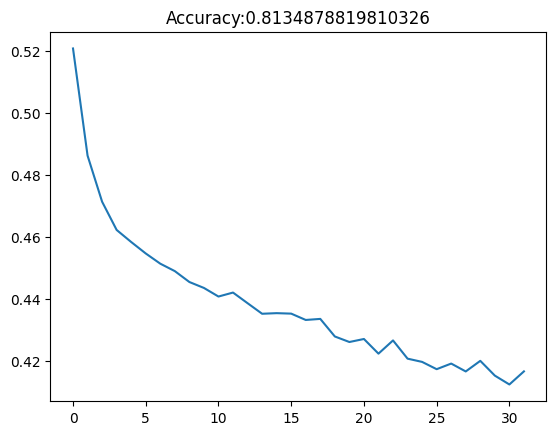

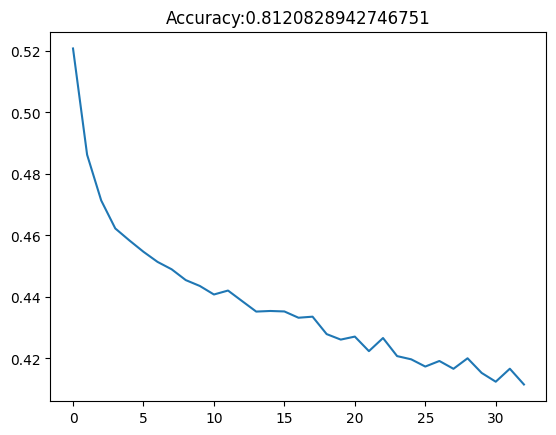

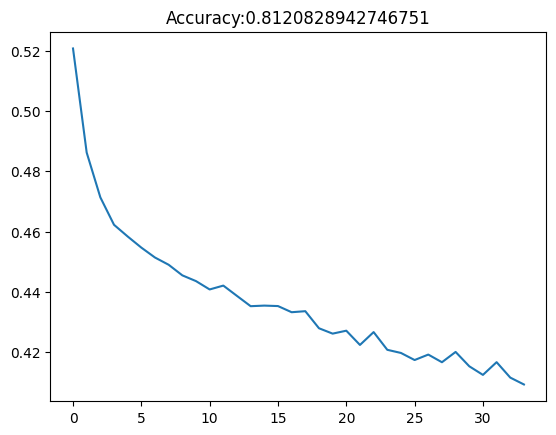

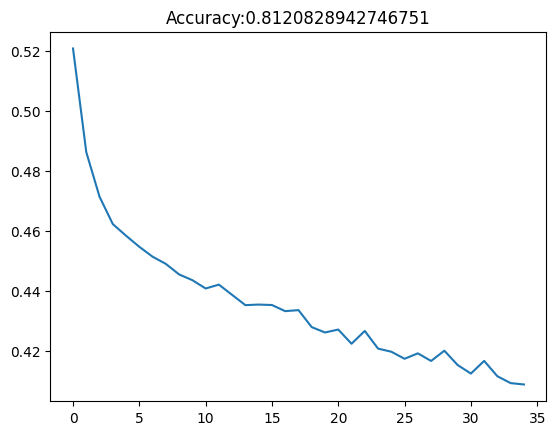

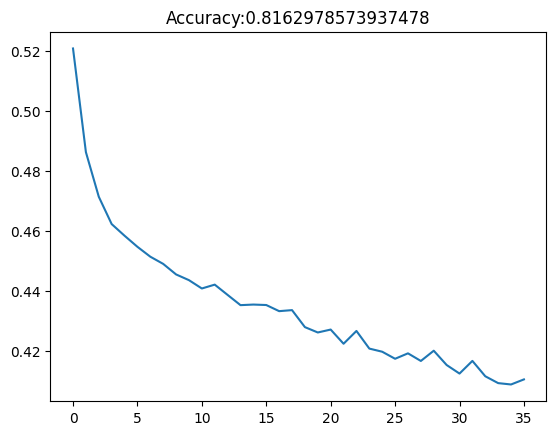

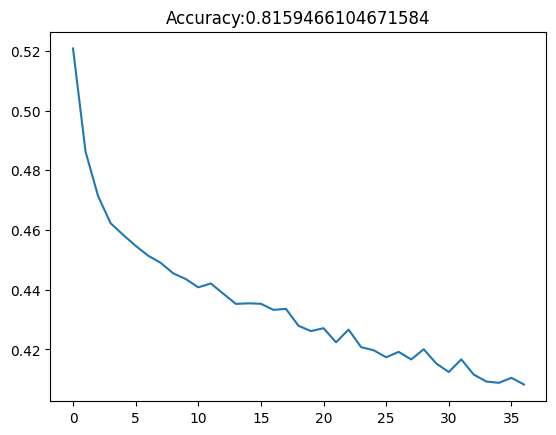

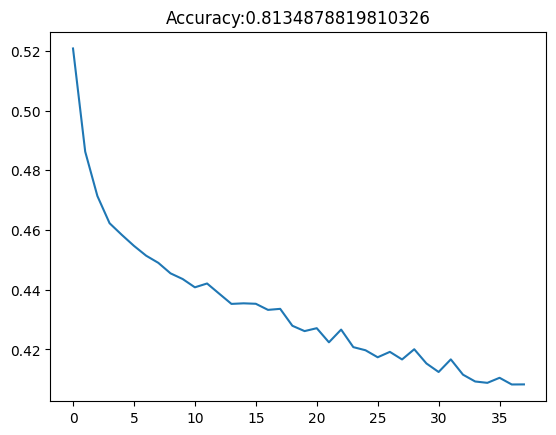

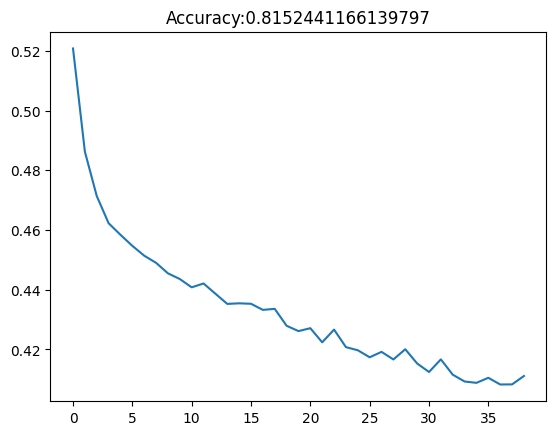

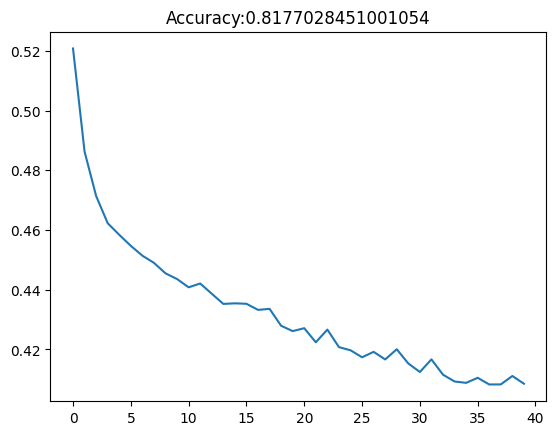

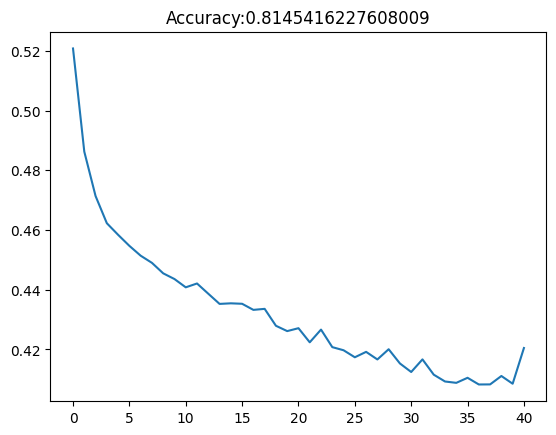

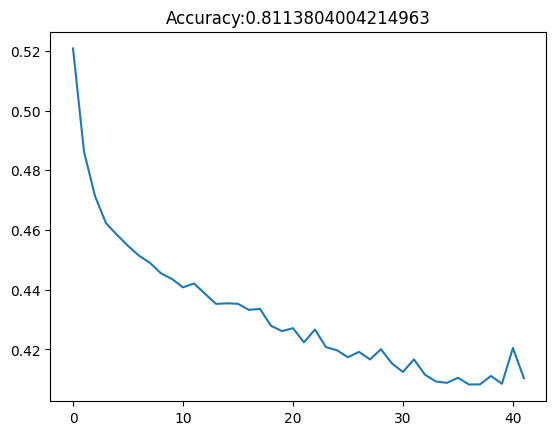

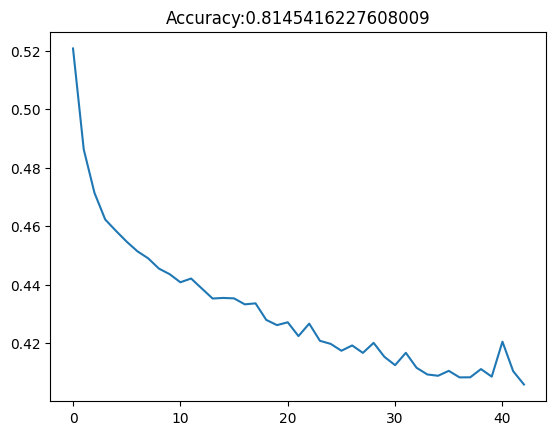

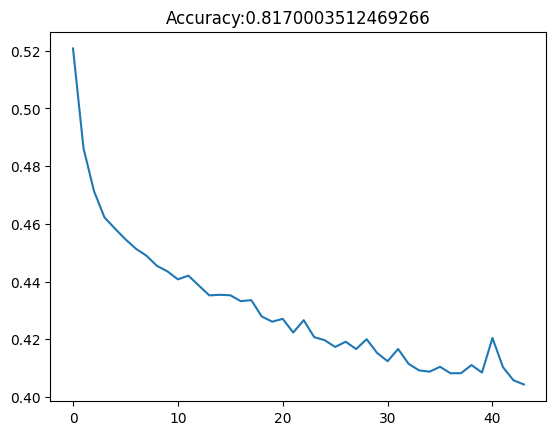

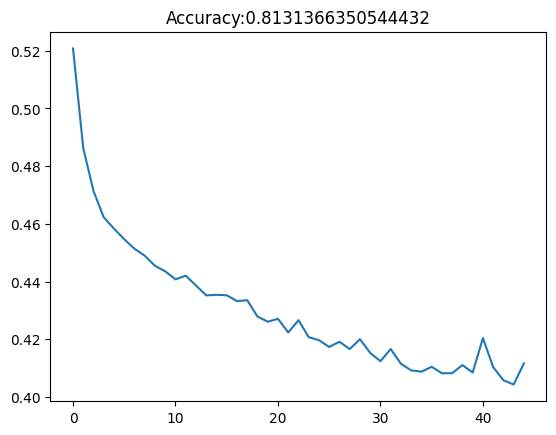

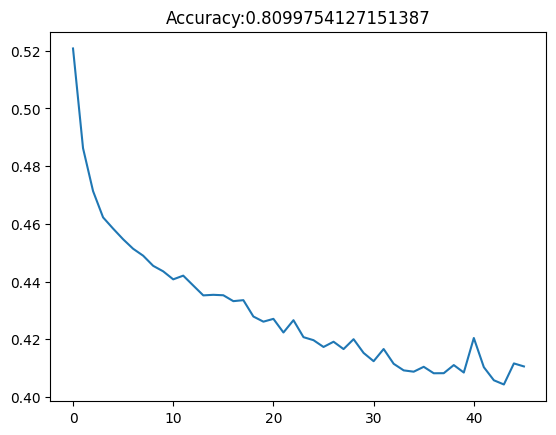

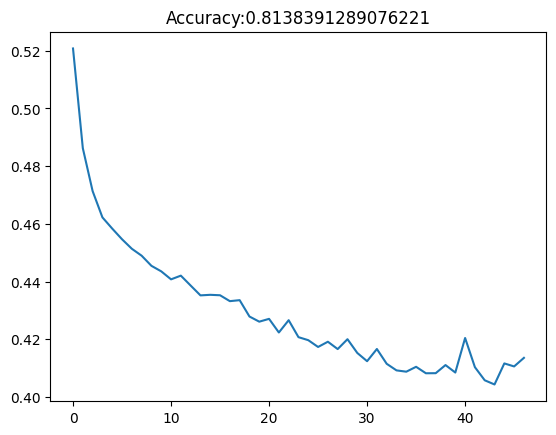

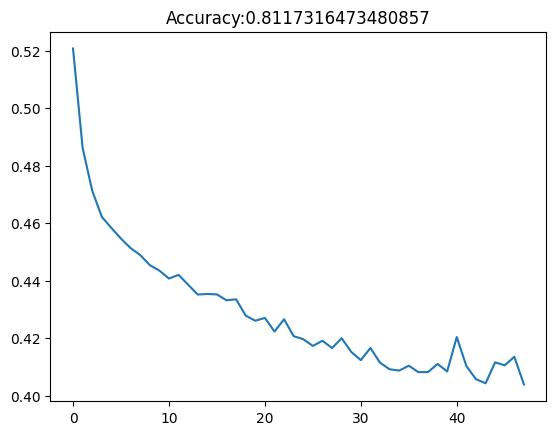

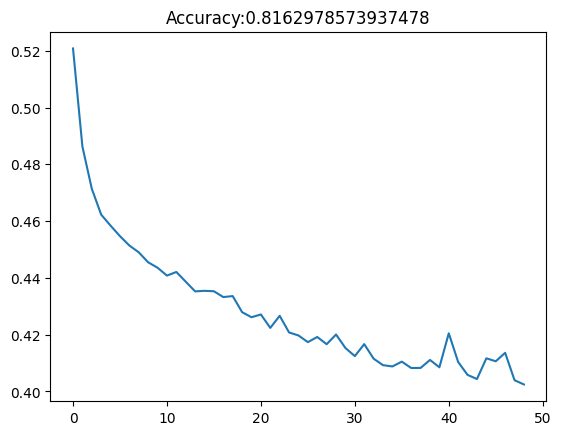

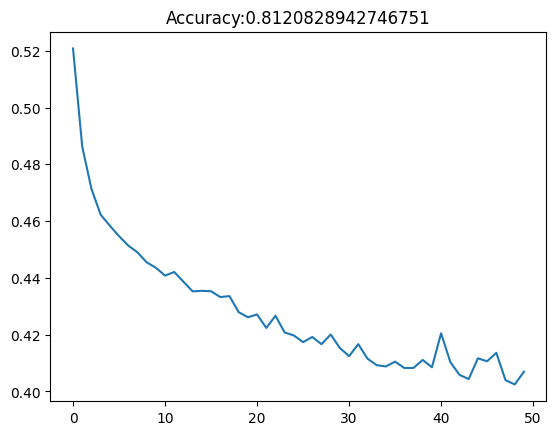

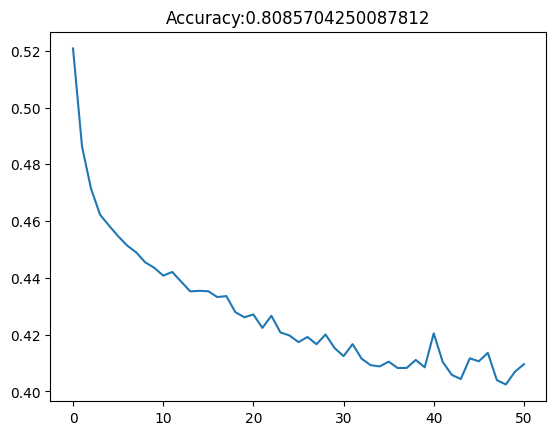

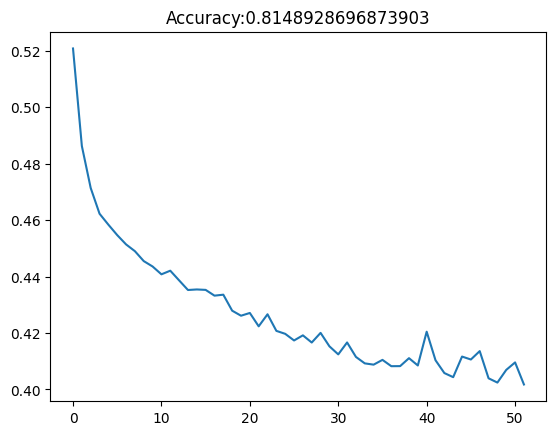

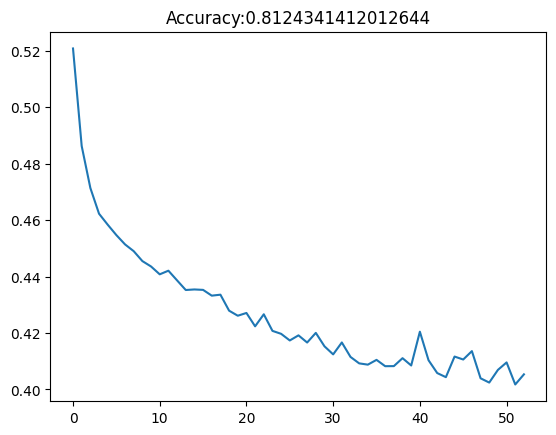

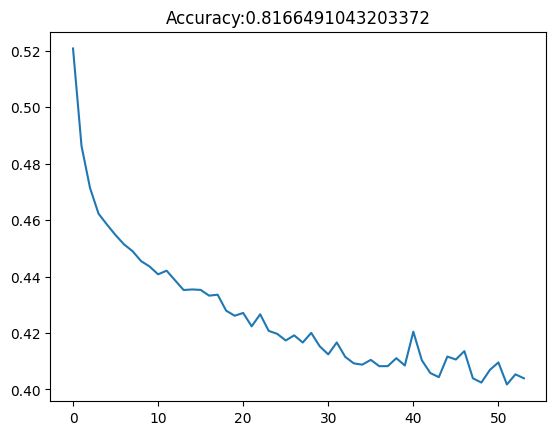

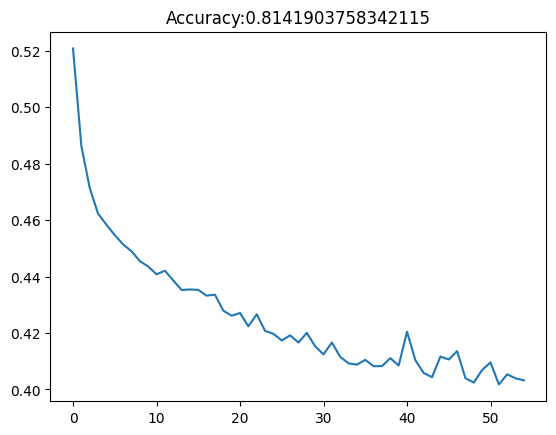

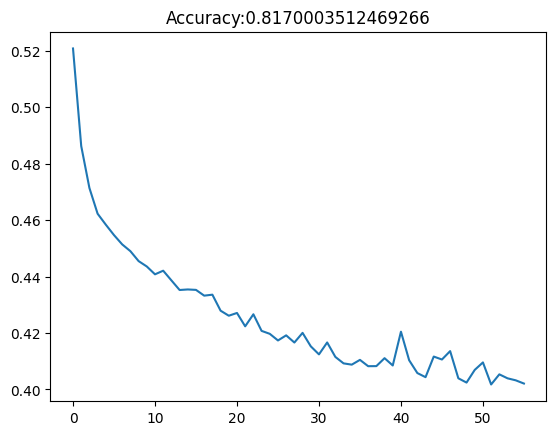

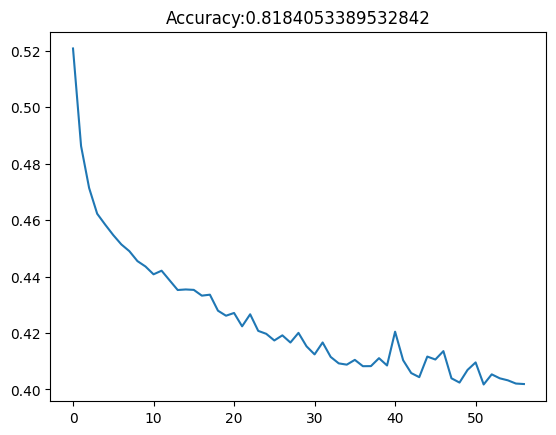

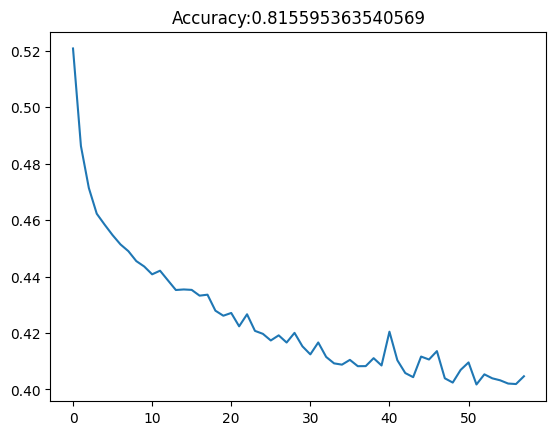

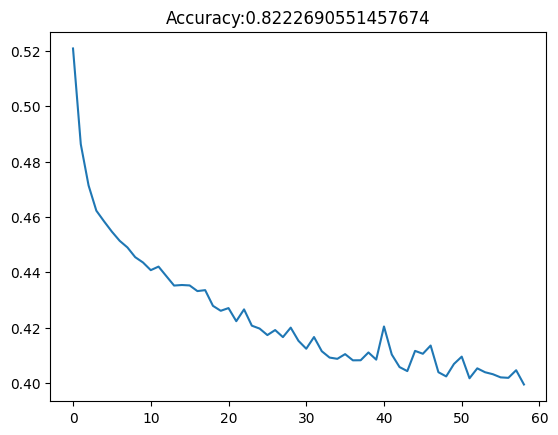

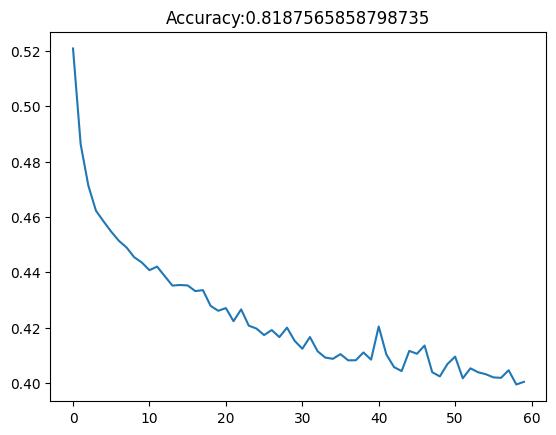

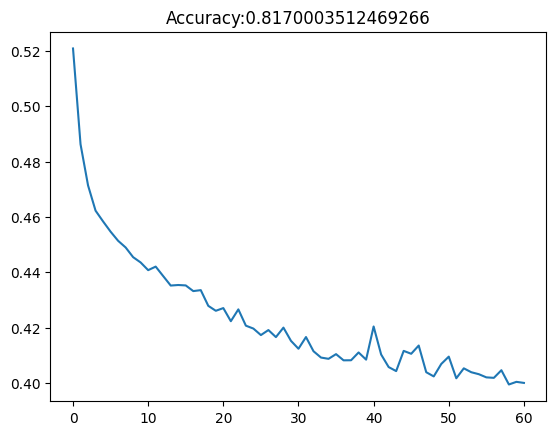

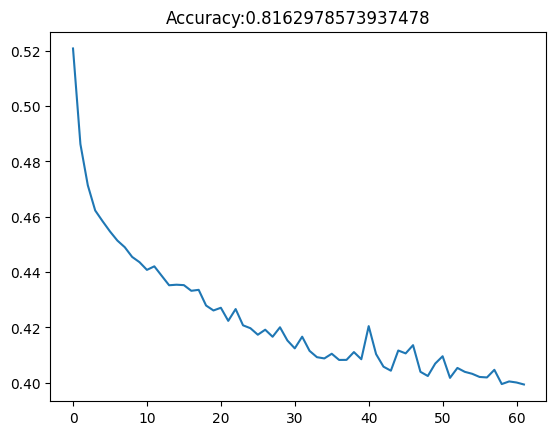

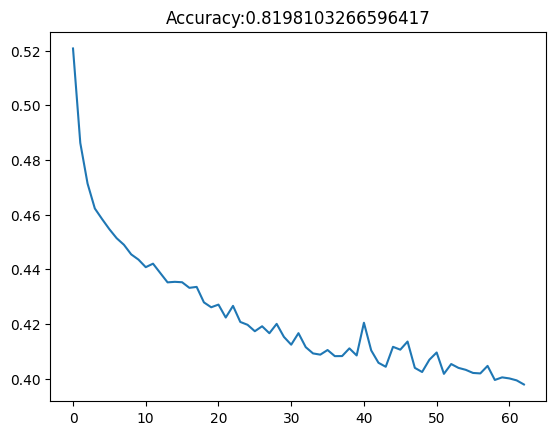

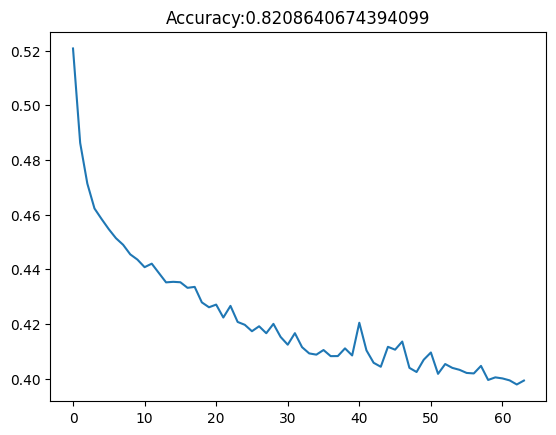

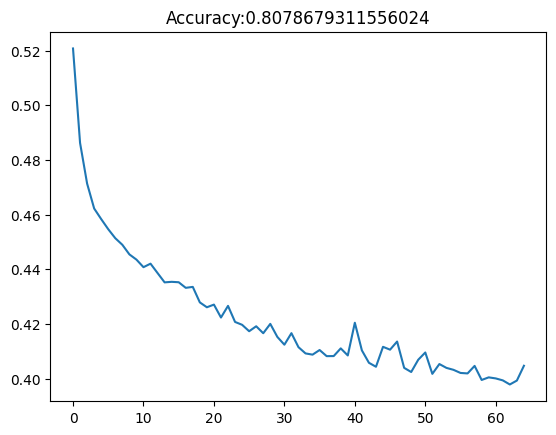

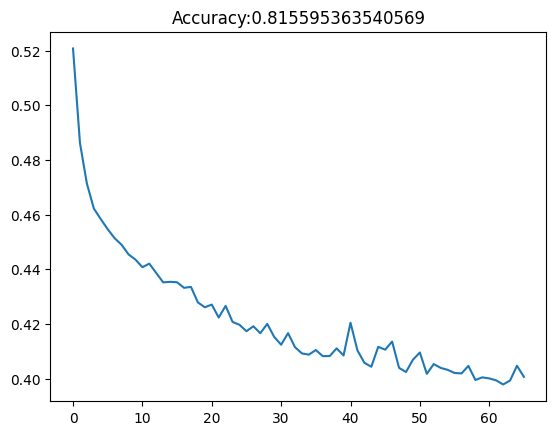

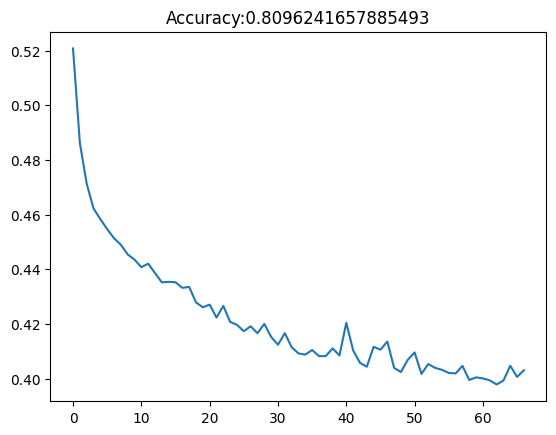

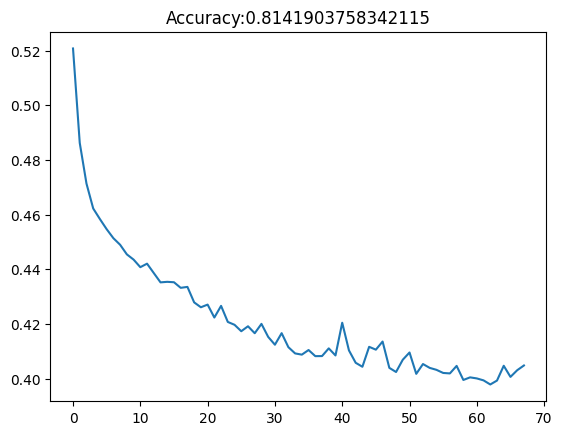

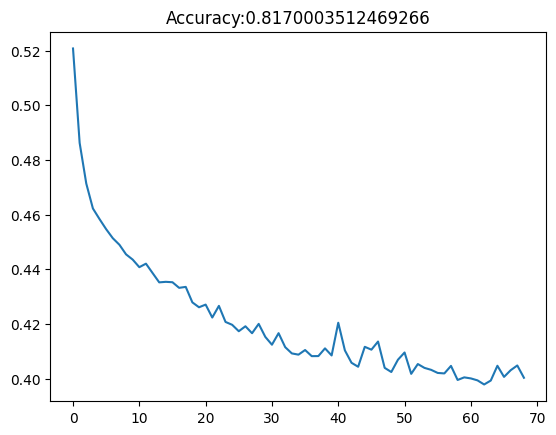

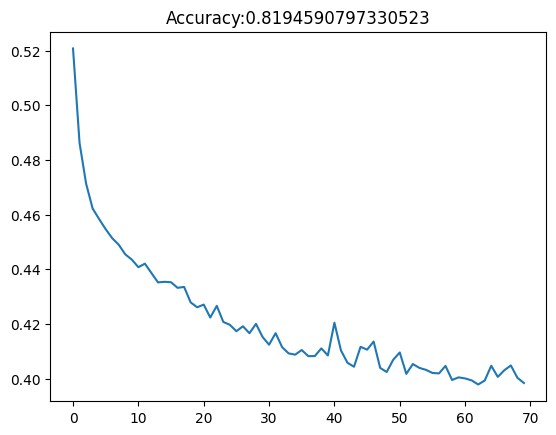

In [14]:
losses=trans.train(X_train,y_train, X_test, y_test, epochs=70, normalisator_1=bn, normalisator_2=bn_2, batch_size=100) #Обучение модели

Сделаем предсказание по стандартному порогу в 0.5:

In [15]:
y_pred=trans.strict_predict(X_test, normalisator_1=bn, normalisator_2=bn_2)#Предсказание

In [16]:
from utils.metrics import accuracy, precision, recall, f_score

In [18]:
print(f"Accuracy: {accuracy(y_pred,y_test)}\nPrecision: {precision(y_pred,y_test)}\nRecall: {recall(y_pred,y_test)}\nf-score: {f_score(y_pred,y_test)}\n")

Accuracy: 0.8194590797330523
Precision: 0.7897503285151117
Recall: 0.6293193717277487
f-score: 0.7004662004662003



Подберём оптимальный порог:

In [19]:
pred_proba=trans.predict(X_test, normalisator_1=bn, normalisator_2=bn_2)

In [23]:
for i in range(1,100):
    res=pred_proba[:,1]>=i/100
    print(f"Порог отсечения: {i/100}")
    print(f"Accuracy: {accuracy(res,y_test)}\nPrecision: {precision(res,y_test)}\nRecall: {recall(res,y_test)}\nf-score: {f_score(res,y_test)}\n")
    print('---------------------------------------------------------------------------')


Порог отсечения: 0.01
Accuracy: 0.35686687741482265
Precision: 0.3427853553481694
Recall: 1.0
f-score: 0.5105586741512964

---------------------------------------------------------------------------
Порог отсечения: 0.02
Accuracy: 0.39199157007376184
Precision: 0.3553318419090231
Recall: 0.9979057591623036
f-score: 0.5240582897992851

---------------------------------------------------------------------------
Порог отсечения: 0.03
Accuracy: 0.4309799789251844
Precision: 0.370471367354889
Recall: 0.9958115183246073
f-score: 0.5400340715502555

---------------------------------------------------------------------------
Порог отсечения: 0.04
Accuracy: 0.47067088162978576
Precision: 0.3873469387755102
Recall: 0.993717277486911
f-score: 0.5574155653450807

---------------------------------------------------------------------------
Порог отсечения: 0.05
Accuracy: 0.5064980681419038
Precision: 0.4040102389078498
Recall: 0.9916230366492147
f-score: 0.5741133676871779

-------------------------

In [24]:
res=pred_proba[:,1]>=0.35
print(f"Порог отсечения: {0.35}")
print(f"Accuracy: {accuracy(res,y_test)}\nPrecision: {precision(res,y_test)}\nRecall: {recall(res,y_test)}\nf-score: {f_score(res,y_test)}\n")

Порог отсечения: 0.35
Accuracy: 0.8159466104671584
Precision: 0.7082125603864734
Recall: 0.7675392670157068
f-score: 0.7366834170854272

